# Video Game Sales & Trends – Data Preparation and Visualisation

This notebook prepares the data for my Data Visualisation coursework.

I use **four datasets**:

1. `vgsales.csv` – classic global video game sales dataset
2. `best_selling_video_games_of_all_time.csv` – all–time best–selling games
3. `steam.csv` – Steam store games metadata (PC releases & genres)
4. `steamspy_tag_data.csv` – SteamSpy tag statistics

In this notebook I will:

- Load and inspect the datasets
- Clean and standardise the main sales dataset (`vgsales`)
- Handle missing data and filter rows
- Create new features (e.g. `Decade`, `Sales_Category`)
- Clean the supporting datasets
- Merge `vgsales` with the best–selling list
- Aggregate data to create “number stories”
- Create Plotly visualisations for my dashboard / infographic
- Export cleaned datasets for reuse


In [40]:
import pandas as pd
import numpy as np
import plotly.express as px

pd.set_option("display.max_columns", 50)
pd.set_option("display.precision", 3)


## 1. Load datasets

Here I load the four CSV files.

> Note: if your files are in a `data/` folder, add `data/` before the filename.
> For example: `"data/vgsales.csv"`.


In [41]:
#loadig datasets from folder (Data)
vgsales = pd.read_csv("../data/processed/vgsales.csv")
best_selling = pd.read_csv("../data/processed/best_selling_video_games_of_all_time.csv")
steam = pd.read_csv("../data/processed/steam.csv")
steam_tags = pd.read_csv("../data/processed/steamspy_tag_data.csv")

print("Raw shapes:")
print("vgsales:", vgsales.shape)
print("best_selling:", best_selling.shape)
print("steam:", steam.shape)
print("steam_tags:", steam_tags.shape)


Raw shapes:
vgsales: (16598, 11)
best_selling: (50, 8)
steam: (27075, 18)
steam_tags: (29022, 372)


### 1.1 Inspect columns

I inspect the column names of each dataset to understand their structure and to decide how to standardise them.


In [42]:
print("vgsales columns:", vgsales.columns.tolist())
print("best_selling columns:", best_selling.columns.tolist())
print("steam columns:", steam.columns.tolist())
print("steam_tags columns:", steam_tags.columns.tolist())


vgsales columns: ['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
best_selling columns: ['Rank', 'Title', 'Sales', 'Series', 'Platform(s)', 'Initial release date', 'Developer(s)', 'Publisher(s)']
steam columns: ['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']
steam_tags columns: ['appid', '1980s', '1990s', '2.5d', '2d', '2d_fighter', '360_video', '3d', '3d_platformer', '3d_vision', '4_player_local', '4x', '6dof', 'atv', 'abstract', 'action', 'action_rpg', 'action_adventure', 'addictive', 'adventure', 'agriculture', 'aliens', 'alternate_history', 'america', 'animation_&_modeling', 'anime', 'arcade', 'arena_shooter', 'artificial_intelligence', 'assassin', 'asynchronous_multiplayer', 'atmospheric', 'audio_produ

## 2. Helper function for flexible column selection

To make the notebook more robust to small naming differences (e.g. `Name` vs `name`),
I use a helper that picks the first existing column from a list of candidates.


In [43]:
def pick_col(df: pd.DataFrame, candidates, df_name="df", required=True):
    """
    Return the first column from `candidates` that exists in df.columns.
    If none found and required=True, raise a clear error.
    """
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of {candidates} found in {df_name} columns: {list(df.columns)}")
    return None


## 3. Clean main sales dataset – `vgsales`

This is the main dataset used for most sales-based visualisations.

Cleaning steps:

- Standardise key columns (Name, Platform, Year, Genre, Global_Sales)
- Convert `Year` and `Global_Sales` to numeric
- Handle missing values in key fields
- Filter out invalid rows (no year, no sales, outside reasonable year range)
- Create new features:
  - `Decade`
  - `Sales_Category` (Low / Medium / High / Very High)


In [44]:
vg = vgsales.copy()

# Identify core columns using flexible matching
name_col     = pick_col(vg, ["Name", "name", "Title", "title", "Game", "game"], "vgsales")
platform_col = pick_col(vg, ["Platform", "platform", "Console", "console"], "vgsales")
year_col     = pick_col(vg, ["Year", "year", "Release_Year", "release_year"], "vgsales")
genre_col    = pick_col(vg, ["Genre", "genre"], "vgsales")
gsales_col   = pick_col(vg, ["Global_Sales", "global_sales", "Global", "total_sales"], "vgsales")

# Build a standardised dataframe
vgsales_clean = pd.DataFrame({
    "Name": vg[name_col],
    "Platform": vg[platform_col],
    "Year": vg[year_col],
    "Genre": vg[genre_col],
    "Global_Sales": vg[gsales_col]
})

print("Before cleaning:", vgsales_clean.shape)

# Convert Year & Global_Sales to numeric
vgsales_clean["Year"] = pd.to_numeric(vgsales_clean["Year"], errors="coerce")
vgsales_clean["Global_Sales"] = pd.to_numeric(vgsales_clean["Global_Sales"], errors="coerce")

# Handle missing data in key columns
before = vgsales_clean.shape[0]
vgsales_clean = vgsales_clean.dropna(subset=["Name", "Platform", "Genre", "Year"])
after = vgsales_clean.shape[0]
print(f"Dropped {before - after} rows with missing Name/Platform/Genre/Year")

# Row filtering: keep only positive sales and reasonable years
vgsales_clean = vgsales_clean[vgsales_clean["Global_Sales"] > 0]
vgsales_clean = vgsales_clean[
    (vgsales_clean["Year"] >= 1980) & (vgsales_clean["Year"] <= 2025)
]

# New feature: Decade
vgsales_clean["Decade"] = (vgsales_clean["Year"] // 10) * 10

# New feature: Sales_Category
vgsales_clean["Sales_Category"] = pd.cut(
    vgsales_clean["Global_Sales"],
    bins=[-0.01, 0.5, 2, 10, vgsales_clean["Global_Sales"].max()],
    labels=["Low", "Medium", "High", "Very High"]
)

print("After cleaning:", vgsales_clean.shape)
vgsales_clean.head()


Before cleaning: (16598, 5)
Dropped 271 rows with missing Name/Platform/Genre/Year
After cleaning: (16327, 7)


,Name,Platform,Year,Genre,Global_Sales,Decade,Sales_Category
0,Wii Sports,Wii,2006.0,Sports,82.74,2000.0,Very High
1,Super Mario Bros.,NES,1985.0,Platform,40.24,1980.0,Very High
2,Mario Kart Wii,Wii,2008.0,Racing,35.82,2000.0,Very High
3,Wii Sports Resort,Wii,2009.0,Sports,33.00,2000.0,Very High
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,31.37,1990.0,Very High


## 4. Clean supporting dataset – Best–selling games

The dataset `best_selling_video_games_of_all_time.csv` provides another view of game sales.
I standardise it and prepare it for merging with `vgsales_clean`.


In [45]:
bs = best_selling.copy()

bs_name_col   = pick_col(bs, ["Name", "name", "Title", "title", "Game", "game"], "best_selling")
bs_sales_col  = pick_col(bs, ["Copies_sold", "Copies Sold", "Global_Sales", "Sales", "Units_sold"], "best_selling")

bs_clean = pd.DataFrame({
    "Name": bs[bs_name_col],
    "Best_Seller_Sales": pd.to_numeric(bs[bs_sales_col], errors="coerce")
})


bs_platform_col = pick_col(bs, ["Platform", "platform", "Console", "console"], "best_selling", required=False)
bs_year_col     = pick_col(bs, ["Year", "year", "Release_Year", "release_year"], "best_selling", required=False)

if bs_platform_col is not None:
    bs_clean["Platform"] = bs[bs_platform_col]
if bs_year_col is not None:
    bs_clean["Year"] = pd.to_numeric(bs[bs_year_col], errors="coerce")

# Drop rows with missing Name or Best_Seller_Sales
before_bs = bs_clean.shape[0]
bs_clean = bs_clean.dropna(subset=["Name", "Best_Seller_Sales"])
after_bs = bs_clean.shape[0]
print(f"Dropped {before_bs - after_bs} rows from best_selling with missing Name/Sales")

print("best_selling_clean shape:", bs_clean.shape)
bs_clean.head()


Dropped 0 rows from best_selling with missing Name/Sales
best_selling_clean shape: (50, 2)


,Name,Best_Seller_Sales
0,Minecraft,238000000
1,Grand Theft Auto V,175000000
2,Tetris (EA),100000000
3,Wii Sports,82900000
4,PUBG: Battlegrounds,75000000


## 5. Clean supporting dataset – Steam games (`steam.csv`)

This dataset focuses on PC games on Steam.
I extract basic fields such as name, release year and genres.


In [46]:
st = steam.copy()

st_name_col  = pick_col(st, ["name", "Name", "title", "Title"], "steam")
st_date_col  = pick_col(st, ["release_date", "Release date", "Release_Date"], "steam", required=False)
st_genre_col = pick_col(st, ["genres", "Genres", "genre", "Genre"], "steam", required=False)
st_price_col = pick_col(st, ["price", "Price"], "steam", required=False)

steam_clean = pd.DataFrame({
    "Name": st[st_name_col]
})

if st_date_col is not None:
    steam_clean["Release_Date"] = st[st_date_col]
    steam_clean["Year"] = pd.to_datetime(steam_clean["Release_Date"], errors="coerce").dt.year

if st_genre_col is not None:
    steam_clean["Genres"] = st[st_genre_col]

if st_price_col is not None:
    steam_clean["Price"] = pd.to_numeric(st[st_price_col], errors="coerce")

# Drop rows with no name
before_st = steam_clean.shape[0]
steam_clean = steam_clean.dropna(subset=["Name"])
after_st = steam_clean.shape[0]
print(f"Dropped {before_st - after_st} rows from steam with missing Name")

print("steam_clean shape:", steam_clean.shape)
steam_clean.head()


Dropped 0 rows from steam with missing Name
steam_clean shape: (27075, 5)


,Name,Release_Date,Year,Genres,Price
0,Counter-Strike,2000-11-01,2000,Action,7.19
1,Team Fortress Classic,1999-04-01,1999,Action,3.99
2,Day of Defeat,2003-05-01,2003,Action,3.99
3,Deathmatch Classic,2001-06-01,2001,Action,3.99
4,Half-Life: Opposing Force,1999-11-01,1999,Action,3.99


## 6. Clean supporting dataset – SteamSpy tag data (`steamspy_tag_data.csv`)

In this dataset, each tag is a separate column (e.g. `action`, `rpg`, `horror`, etc.),
with numeric values indicating how strongly that tag is associated with a game.

There is no single `"tags"` column.
Instead, I treat all columns except `appid` as tags and sum them across all games
to get the overall popularity/frequency of each tag.


In [47]:
tags = steam_tags.copy()

# 'appid' identifies the game; all other columns are tag indicators/counts.
tag_columns = [c for c in tags.columns if c != "appid"]

print(f"Number of tag columns: {len(tag_columns)}")
print("First 10 tag columns:", tag_columns[:10])

# Sum each tag column over all games to get a global "score" / frequency
tag_sums = tags[tag_columns].sum(axis=0)

tag_counts = (
    tag_sums
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "Tag", 0: "Count"})
)

print("tag_counts shape:", tag_counts.shape)
tag_counts.head(20)


Number of tag columns: 371
First 10 tag columns: ['1980s', '1990s', '2.5d', '2d', '2d_fighter', '360_video', '3d', '3d_platformer', '3d_vision', '4_player_local']
tag_counts shape: (371, 2)


,Tag,Count
0,action,763849
1,indie,730458
2,adventure,563927
3,multiplayer,415341
4,singleplayer,403390
5,casual,327532
6,rpg,318176
7,strategy,312526
8,open_world,312337
9,simulation,282366


## 7. Merge vgsales with best–selling games

To demonstrate merging across datasets, I join the cleaned `vgsales` data
with the best–selling games list using a normalised game name key.


In [48]:
# Normalise names for joining (lowercase, stripped)
vgsales_merge = vgsales_clean.copy()
vgsales_merge["Name_key"] = vgsales_merge["Name"].str.lower().str.strip()

bs_merge = bs_clean.copy()
bs_merge["Name_key"] = bs_merge["Name"].str.lower().str.strip()

merged = pd.merge(
    vgsales_merge,
    bs_merge[["Name_key", "Best_Seller_Sales"]],
    on="Name_key",
    how="inner"
)

print("merged shape:", merged.shape)
merged[["Name", "Platform", "Year", "Global_Sales", "Best_Seller_Sales"]].head(10)


merged shape: (69, 9)


,Name,Platform,Year,Global_Sales,Best_Seller_Sales
0,Wii Sports,Wii,2006.0,82.74,82900000
1,Super Mario Bros.,NES,1985.0,40.24,58000000
2,Mario Kart Wii,Wii,2008.0,35.82,37380000
3,Wii Sports Resort,Wii,2009.0,33.00,33140000
4,New Super Mario Bros.,DS,2006.0,30.01,30800000
5,Wii Play,Wii,2006.0,29.02,28020000
6,New Super Mario Bros. Wii,Wii,2009.0,28.62,30320000
7,Duck Hunt,NES,1984.0,28.31,28300000
8,Nintendogs,DS,2005.0,24.76,23960000
9,Mario Kart DS,DS,2005.0,23.42,23600000


## 8. Aggregations – "Number stories" from the datasets

Here I aggregate the cleaned data to build the basis for my visualisations:

- Top 10 games by global sales
- Top 10 genres by global sales
- Top 10 platforms by global sales
- Sales by decade and genre
- Steam games per year
- Top Steam tags


In [49]:
# Top 10 games by global sales
top10_games = (
    vgsales_clean
    .sort_values("Global_Sales", ascending=False)
    .head(10)
)

# Top 10 genres by global sales
genre_sales = (
    vgsales_clean
    .groupby("Genre")["Global_Sales"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
genre_top10 = genre_sales.head(10)

# Top 10 platforms by global sales
platform_sales = (
    vgsales_clean
    .groupby("Platform")["Global_Sales"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
platform_top10 = platform_sales.head(10)

# Sales by decade & genre
decade_genre = (
    vgsales_clean
    .groupby(["Decade", "Genre"])["Global_Sales"]
    .sum()
    .reset_index()
)

# Rebuild Steam games per year from steam_clean

if "Year" in steam_clean.columns:
    steam_games_per_year = (
        steam_clean
        .dropna(subset=["Year"])                 # remove rows without a year
        .groupby("Year")                         # group by Year
        .size()                                  # count games
        .reset_index(name="Count")              # -> columns: Year, Count
        .sort_values("Year")                    # sort by Year ascending
    )
else:
    steam_games_per_year = pd.DataFrame(columns=["Year", "Count"])

print(steam_games_per_year.head())
print(steam_games_per_year.columns)

# Top 20 Steam tags
top20_tags = tag_counts.head(20)

top10_games, genre_top10, platform_top10, decade_genre.head(), steam_games_per_year.head(), top20_tags.head()


   Year  Count
0  1997      1
1  1998      1
2  1999      2
3  2000      2
4  2001      4
Index(['Year', 'Count'], dtype='object')


(                        Name Platform    Year         Genre  Global_Sales  \
 0                 Wii Sports      Wii  2006.0        Sports         82.74   
 1          Super Mario Bros.      NES  1985.0      Platform         40.24   
 2             Mario Kart Wii      Wii  2008.0        Racing         35.82   
 3          Wii Sports Resort      Wii  2009.0        Sports         33.00   
 4   Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing         31.37   
 5                     Tetris       GB  1989.0        Puzzle         30.26   
 6      New Super Mario Bros.       DS  2006.0      Platform         30.01   
 7                   Wii Play      Wii  2006.0          Misc         29.02   
 8  New Super Mario Bros. Wii      Wii  2009.0      Platform         28.62   
 9                  Duck Hunt      NES  1984.0       Shooter         28.31   
 
    Decade Sales_Category  
 0  2000.0      Very High  
 1  1980.0      Very High  
 2  2000.0      Very High  
 3  2000.0      Very High  


## 9. Plotly visualisations

These visualisations form the basis of my dashboard / infographic.


Top 10 games

In [50]:
fig_top_games = px.bar(
    top10_games,
    x="Global_Sales",
    y="Name",
    orientation="h",
    title="Top 10 Games by Global Sales",
    labels={"Global_Sales": "Global Sales (millions)", "Name": "Game"}
)
fig_top_games.update_layout(yaxis={"categoryorder": "total ascending"})
fig_top_games.show()


Top 10 genres

In [51]:
fig_genre = px.bar(
    genre_top10,
    x="Genre",
    y="Global_Sales",
    title="Top 10 Genres by Global Sales",
    labels={"Global_Sales": "Global Sales (millions)", "Genre": "Genre"}
)
fig_genre.show()


Top platforms

In [52]:
fig_platform = px.bar(
    platform_top10,
    x="Platform",
    y="Global_Sales",
    title="Top 10 Platforms by Global Sales",
    labels={"Global_Sales": "Global Sales (millions)", "Platform": "Platform"}
)
fig_platform.show()


Sales by decade & genre

In [53]:
fig_decade = px.bar(
    decade_genre,
    x="Decade",
    y="Global_Sales",
    color="Genre",
    title="Global Sales by Decade and Genre",
    labels={"Global_Sales": "Global Sales (millions)", "Decade": "Decade"}
)
fig_decade.show()


Steam games per year

In [54]:
if not steam_games_per_year.empty:
    fig_steam_year = px.bar(
        steam_games_per_year,
        x="Year",
        y="Count",
        title="Number of Steam Games Released per Year",
        labels={"Count": "Number of Games", "Year": "Year"}
    )
    fig_steam_year.show()


Top Steam tags

In [55]:
fig_tags = px.bar(
    top20_tags,
    x="Tag",
    y="Count",
    title="Top 20 Steam Tags (SteamSpy)",
    labels={"Tag": "Tag", "Count": "Frequency"}
)
fig_tags.show()


# Total number of games in the cleaned dataset

In [56]:
total_games = len(vgsales_clean)
print("Total games:", total_games)


Total games: 16327


In [57]:
top_genre_row = genre_sales.iloc[0]
top_genre_name = top_genre_row["Genre"]
top_genre_sales = top_genre_row["Global_Sales"]

print(top_genre_name, top_genre_sales)


Action 1722.88


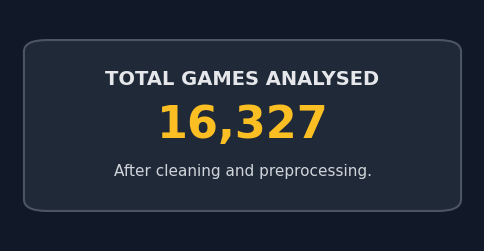

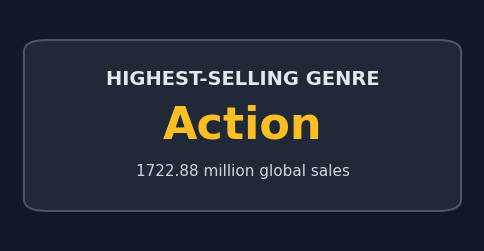

In [58]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def kpi_card(title, main_text, subtitle=None):
    fig, ax = plt.subplots(figsize=(6, 3))

    # Dark background (card-style)
    fig.patch.set_facecolor("#111827")
    ax.set_facecolor("#111827")
    ax.axis("off")

    # Rounded rectangle "card"
    box = FancyBboxPatch(
        (0.05, 0.15), 0.9, 0.7,
        boxstyle="round,pad=0.02,rounding_size=0.05",
        linewidth=1.5,
        edgecolor="#4B5563",
        facecolor="#1F2937"
    )
    ax.add_patch(box)

    # Title
    ax.text(
        0.5, 0.7, title,
        ha="center", va="center",
        fontsize=14, fontweight="bold",
        color="#E5E7EB", transform=ax.transAxes
    )

    # Main value
    ax.text(
        0.5, 0.5, main_text,
        ha="center", va="center",
        fontsize=32, fontweight="bold",
        color="#FBBF24", transform=ax.transAxes
    )

    # Subtitle (optional)
    if subtitle:
        ax.text(
            0.5, 0.3, subtitle,
            ha="center", va="center",
            fontsize=11,
            color="#D1D5DB", transform=ax.transAxes
        )

    plt.show()

# Card 1: Total games
kpi_card(
    "TOTAL GAMES ANALYSED",
    f"{total_games:,}",
    "After cleaning and preprocessing."
)

# Card 2: Highest-selling genre
kpi_card(
    "HIGHEST-SELLING GENRE",
    top_genre_name,
    f"{top_genre_sales:.2f} million global sales"
)


## 10. Export cleaned datasets

Finally, I export the cleaned data so it can be easily reused in the dashboard
and as evidence of the data preparation process.


In [59]:
vgsales_clean.to_csv("final_vgsales_clean.csv", index=False)
bs_clean.to_csv("final_best_selling_clean.csv", index=False)
steam_clean.to_csv("final_steam_clean.csv", index=False)
merged.to_csv("final_merged_vgsales_best_selling.csv", index=False)

print("Exported final datasets:")
print(" - final_vgsales_clean.csv")
print(" - final_best_selling_clean.csv")
print(" - final_steam_clean.csv")
print(" - final_merged_vgsales_best_selling.csv")


Exported final datasets:
 - final_vgsales_clean.csv
 - final_best_selling_clean.csv
 - final_steam_clean.csv
 - final_merged_vgsales_best_selling.csv
